# Data Pre-Processing and Analytics (Part 1)
This notebook demonstrates basic methods of data pre-processing and analytics.

In [2]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import requests

load_dotenv()
api_key = os.getenv('fmp_api_key')
url_base = "https://financialmodelingprep.com/stable/"

constituents = requests.get(url=f"{url_base}sp500-constituent", params={'apikey': api_key}).json()
df_constituents = pd.DataFrame(constituents)
df_constituents.head()

,symbol,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded
0,IBKR,Interactive Brokers Group,Financial Services,Investment - Banking & Investment Services,"Greenwich, CT",2025-08-28,0001381197,1982
1,XYZ,"Block, Inc.",Technology,Software - Infrastructure,"Oakland, California",2025-07-23,0001512673,2009
2,TTD,"The Trade Desk, Inc.",Technology,Software - Application,"Ventura, California",2025-07-18,0001671933,2009
3,DDOG,Datadog,Technology,Software - Application,"New York City, New York",2025-07-09,0001561550,2010
4,COIN,Coinbase Global,Financial Services,Financial - Data & Stock Exchanges,"Wilmington, Delaware",2025-05-19,0001679788,2012


In [3]:
from us import states as us_states

df_constituents['dateFirstAdded'] = pd.to_datetime(df_constituents['dateFirstAdded'])
df_constituents['yearAdded'] = df_constituents['dateFirstAdded'].dt.year

df_constituents['headQuarterState'] = df_constituents['headQuarter'].str.split(',').str[1].str.strip()
us_abbr_to_name = {s.abbr: s.name for s in us_states.STATES + [us_states.DC]}
df_constituents['headQuarterState'] = df_constituents['headQuarterState'].apply(lambda x: us_abbr_to_name.get(x, x))

df_constituents = df_constituents.drop(columns=['founded','dateFirstAdded', 'cik', 'headQuarter'])
df_constituents = df_constituents.rename(columns={
    'symbol': 'ticker',
    'subSector': 'subsector',
    'yearAdded': 'year_added',
    'headQuarterState': 'headquarter_state'
})
df_constituents.to_csv("data/sp500_constituents.csv", index=False)
df_constituents.head()

,ticker,name,sector,subsector,year_added,headquarter_state
0,IBKR,Interactive Brokers Group,Financial Services,Investment - Banking & Investment Services,2025,Connecticut
1,XYZ,"Block, Inc.",Technology,Software - Infrastructure,2025,California
2,TTD,"The Trade Desk, Inc.",Technology,Software - Application,2025,California
3,DDOG,Datadog,Technology,Software - Application,2025,New York
4,COIN,Coinbase Global,Financial Services,Financial - Data & Stock Exchanges,2025,Delaware


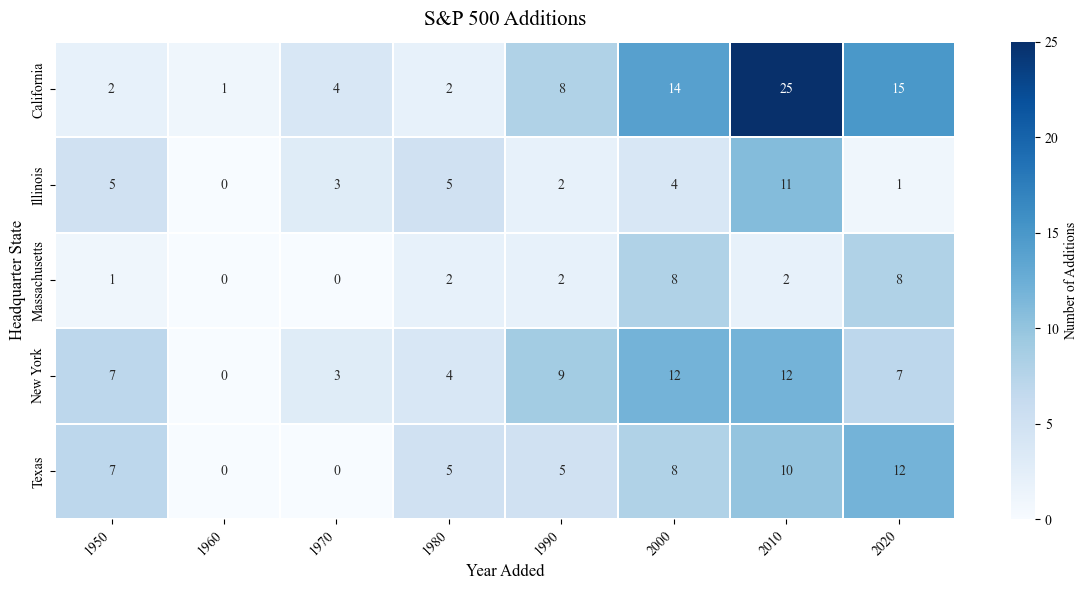

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

common_states = df_constituents['headquarter_state'].value_counts().head(5).index
common_states_decade_counts = (
    df_constituents[df_constituents['headquarter_state'].isin(common_states)]
    .assign(decade=(df_constituents['year_added']//10)*10)
    .pivot_table(index="headquarter_state", columns="decade", values="ticker", aggfunc="count", fill_value=0)
)

mpl.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12,6))
sns.heatmap(common_states_decade_counts, cmap="Blues", annot=True, linewidths=0.1, cbar_kws={'label': 'Number of Additions'})
plt.title("S&P 500 Additions", fontsize=15, pad=12)
plt.xlabel("Year Added", fontsize=12)
plt.ylabel("Headquarter State", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

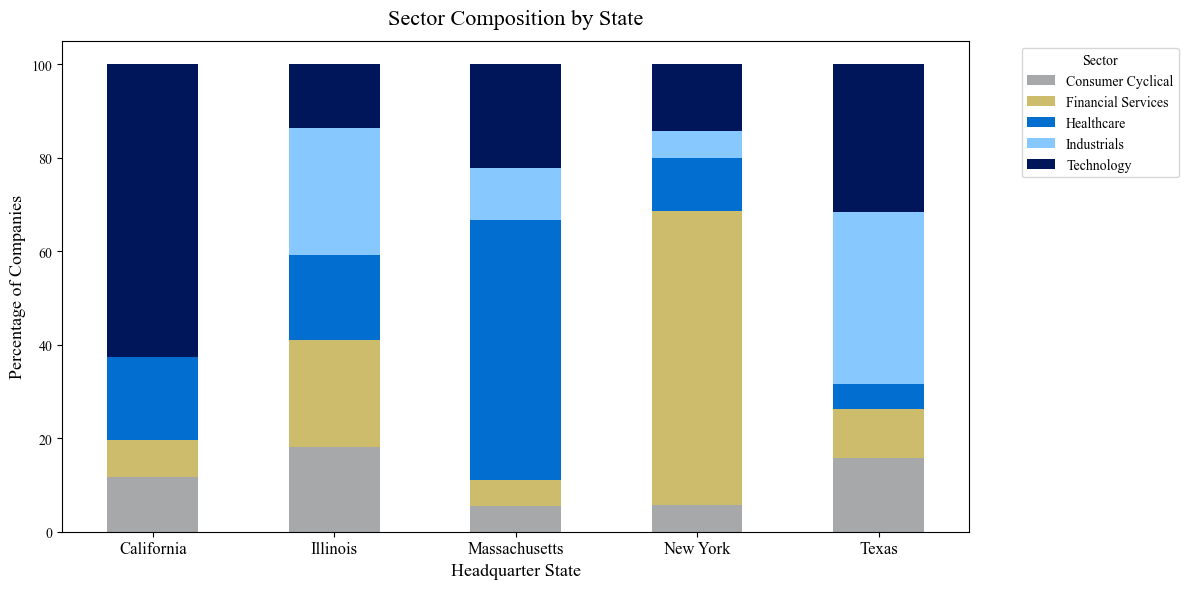

In [5]:
common_sectors = df_constituents['sector'].value_counts().head(5).index
common_states_sector_counts = (
    df_constituents[df_constituents['headquarter_state'].isin(common_states) & df_constituents['sector'].isin(common_sectors)]
    .pivot_table(index="headquarter_state", columns="sector", values="ticker", aggfunc="count", fill_value=0)
)
common_states_sector_pct = common_states_sector_counts.div(common_states_sector_counts.sum(axis=1), axis=0) * 100

custom_colors = ['#a7a8aa', '#cdbc6c', '#026fd0', '#87c8ff', '#00165b']

plt.figure(figsize=(12,6))
common_states_sector_pct.plot(
    kind="bar",
    stacked=True,
    color=custom_colors,
    ax=plt.gca()
)

plt.title("Sector Composition by State", fontsize=16, pad=12)
plt.xlabel("Headquarter State", fontsize=13)
plt.ylabel("Percentage of Companies", fontsize=13)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

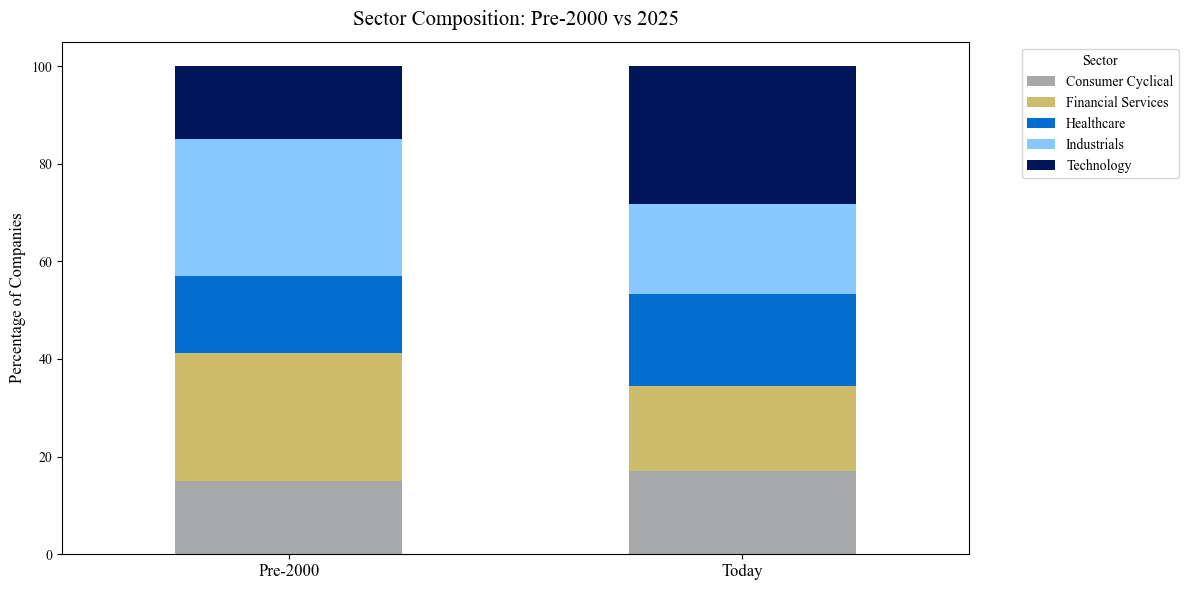

In [6]:
df_common_sectors = df_constituents[df_constituents['sector'].isin(common_sectors)].copy()
df_common_sectors['period'] = np.where(df_common_sectors['year_added'] < 2000, 'Pre-2000', 'Today')

sector_period_counts = df_common_sectors.pivot_table(
    index='sector', columns='period', values='ticker', aggfunc='count', fill_value=0
)
sector_period_pct = sector_period_counts.div(sector_period_counts.sum(axis=0), axis=1) * 100
sector_period_pct = sector_period_pct[['Pre-2000', 'Today']]

plt.figure(figsize=(12, 6))
ax = sector_period_pct.T.plot(
    kind="bar",
    stacked=True,
    color=custom_colors,
    ax=plt.gca()
)

plt.title("Sector Composition: Pre-2000 vs 2025", fontsize=15, pad=12)
plt.xlabel("")
plt.ylabel("Percentage of Companies", fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [7]:
ENDPOINTS = [
    {
        "name": "income_statement",
        "url": f"{url_base}income-statement",
        "params": {"period": "annual", "limit": 100}
    },
    {
        "name": "balance_sheet",
        "url": f"{url_base}balance-sheet-statement",
        "params": {"period": "annual", "limit": 100}
    },
    {
        "name": "cashflow_statement",
        "url": f"{url_base}cash-flow-statement",
        "params": {"period": "annual", "limit": 100}
    },
    {
        "name": "financial_metrics",
        "url": f"{url_base}key-metrics",
        "params": {"period": "annual", "limit": 100}
    },
    {
        "name": "financial_ratios",
        "url": f"{url_base}ratios",
        "params": {"period": "annual", "limit": 100}
    },
    {
        "name": "income_statement_growth",
        "url": f"{url_base}income-statement-growth",
        "params": {"period": "annual", "limit": 100}
    },
    {
        "name": "balance_sheet_growth",
        "url": f"{url_base}balance-sheet-statement-growth",
        "params": {"period": "annual", "limit": 100}
    },
    {
        "name": "cashflow_statement_growth",
        "url": f"{url_base}cash-flow-statement-growth",
        "params": {"period": "annual", "limit": 100}
    },
    {
        "name": "dividend_adjusted_prices",
        "url": f"{url_base}historical-price-eod/dividend-adjusted",
        "params": {"from": "2000-01-01", "to": "2025-01-01"}
    }
]

index_data = requests.get(url=f"{url_base}historical-price-eod/dividend-adjusted", params={"from": "2000-01-01", "to": "2025-01-01", "symbol": "SPY", "apikey": api_key}).json()
df_index = pd.DataFrame(index_data)
df_index.head()

,symbol,date,adjOpen,adjHigh,adjLow,adjClose,volume
0,SPY,2024-12-31,586.41,587.13,580.95,582.60,57052700
1,SPY,2024-12-30,584.40,588.23,580.94,584.73,56578800
2,SPY,2024-12-27,593.99,594.23,587.26,591.48,64969310
3,SPY,2024-12-26,595.94,598.90,594.53,597.77,41338891
4,SPY,2024-12-24,592.52,597.77,591.93,597.73,33160100


In [8]:
dataset = {}

for ep in ENDPOINTS:
    temp = []
    print(f"Fetching {ep['name']} data")
    for ticker in df_constituents["ticker"]:
        params = {**ep["params"], "symbol": ticker, "apikey": api_key}
        data = requests.get(url=ep["url"], params=params).json()
        if data:
            df_temp = pd.DataFrame(data)
            temp.append(df_temp)
    dataset[ep["name"]] = pd.concat(temp, ignore_index=True) if temp else pd.DataFrame()

dataset["income_statement"].head()

Fetching income_statement data
Fetching balance_sheet data
Fetching cashflow_statement data
Fetching financial_metrics data


/var/folders/x2/36b44cxs7fxf1dzfvnf_byr00000gn/T/ipykernel_50020/2054657771.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset[ep["name"]] = pd.concat(temp, ignore_index=True) if temp else pd.DataFrame()


Fetching financial_ratios data
Fetching income_statement_growth data
Fetching balance_sheet_growth data
Fetching cashflow_statement_growth data
Fetching dividend_adjusted_prices data


,date,symbol,reportedCurrency,cik,filingDate,acceptedDate,fiscalYear,period,revenue,costOfRevenue,...,netIncomeFromContinuingOperations,netIncomeFromDiscontinuedOperations,otherAdjustmentsToNetIncome,netIncome,netIncomeDeductions,bottomLineNetIncome,eps,epsDiluted,weightedAverageShsOut,weightedAverageShsOutDil
0,2024-12-31,IBKR,USD,0001381197,2025-03-05,2025-02-27 17:02:30,2024,FY,9316000000,1021000000,...,3407000000,0.0,0.0,755000000,0.0,755000000,1.7500,1.7300,432448000,436012000
1,2023-12-31,IBKR,USD,0001381197,2023-12-31,2023-12-30 19:00:00,2023,FY,7787000000,913000000,...,2812000000,0.0,0.0,600000000,0.0,600000000,1.4300,1.4175,419860000,423388000
2,2022-12-31,IBKR,USD,0001381197,2023-02-24,2023-02-24 16:05:50,2022,FY,4192000000,778000000,...,1842000000,0.0,0.0,380000000,0.0,380000000,0.9450,0.9375,401840000,405200000
3,2021-12-31,IBKR,USD,0001381197,2022-02-25,2022-02-25 17:24:08,2021,FY,2940000000,635000000,...,1636000000,0.0,0.0,308000000,0.0,308000000,0.8175,0.8100,376672000,380040000
4,2020-12-31,IBKR,USD,0001381197,2021-03-01,2021-03-01 06:23:58,2020,FY,2420000000,618000000,...,1179000000,0.0,0.0,195000000,0.0,195000000,0.6100,0.6050,319756000,322556000


In [9]:
df_index.to_csv("data/index_data.csv", index=False)
for name, df in dataset.items():
    path = f"data/{name}.csv"
    df.to_csv(path, index=False)
    print(f"Saved {name} -> {path}")

Saved income_statement -> data/income_statement.csv
Saved balance_sheet -> data/balance_sheet.csv
Saved cashflow_statement -> data/cashflow_statement.csv
Saved financial_metrics -> data/financial_metrics.csv
Saved financial_ratios -> data/financial_ratios.csv
Saved income_statement_growth -> data/income_statement_growth.csv
Saved balance_sheet_growth -> data/balance_sheet_growth.csv
Saved cashflow_statement_growth -> data/cashflow_statement_growth.csv
Saved dividend_adjusted_prices -> data/dividend_adjusted_prices.csv


---

Part 2 will continue with basic methods of data pre-processing and analytics.